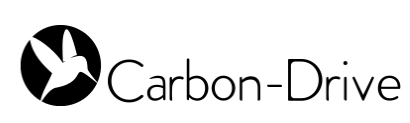
# Carbon-Drive Bandagenabschätzung
- Autor: Dr.-Ing. Martin Klimach, klimach@carbon-drive.de, 06150 830 92 38
- Version: 0.5
- Datum: 08.04.2021
- Version: 0.6
- Datum: 18.05.2021
- Anderungen: Implementierung einer neuen Magnetgeometrie

In [1]:
import numpy as np
import sympy as sp
from ipywidgets import interact, fixed
import ipywidgets as widgets
from matplotlib import pyplot as plt
import matplotlib

## Rechteck mit Dom
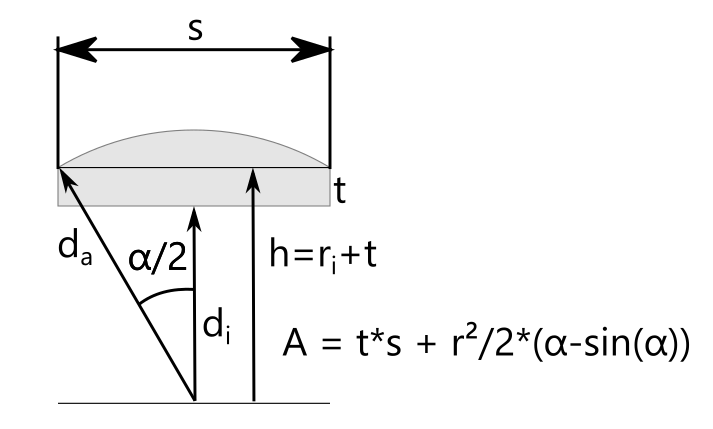

In [2]:
## Allgemeine Berechnungen
# Fläche Kreisabschnitt
d_a, d_i, s, alpha, d_s = sp.symbols('d_a d_i s alpha d_s')
r_a = d_a/2
r_i = d_i/2
r_s = d_s/2
alpha = sp.solve(2*r_a*sp.sin(alpha/2)-s,alpha)[1]
h = r_a*sp.cos(alpha/2)
A_kreis = r_a**2/2*(alpha-sp.sin(alpha))
# Fläche Rechteck
A_rechteck = s*(h-r_i)
#Magnet
A_magnet = A_kreis + A_rechteck
#Schwerpunkt
A_innen = s*(r_s-r_i)
A_aussen = A_rechteck-A_innen+A_kreis
d_magnet = sp.solve(A_innen - A_aussen, d_s)[0]
b_magnet = r_a*alpha



In [3]:
print('Define by inner diameter')
@interact(
    n = widgets.IntSlider(min=1000, max=100000, step=1000, value=22000), #rpm
    d_innen = widgets.FloatSlider(min=10,max=500,step=.5,value=110), #mm Durchmesser am Inneren der Magnete
    h = widgets.FloatSlider(min=0.1,max=50,step=.1,value=(143-110)/2), #mm höhe bis zum Aussendurchmesser
    breite = widgets.FloatSlider(min=1, max=100, step=0.5, value=49), #mm Breite der Magnete
    dichte = fixed(7.85), #g/cm³ Dichte des Magneten
    d_magnet = fixed(d_magnet),
    b_magnet = fixed(b_magnet),
    A_magnet = fixed(A_magnet),
    )
def minimalste_bandagendicke(n,d_innen,h,breite,dichte,d_magnet,b_magnet,A_magnet):
    ## Eingaben
    n = n #rpm
    d_innen = d_innen*1e-3 #m Durchmesser am Inneren der Magnete
    d_aussen = d_innen+2*h*1e-3 #m Durchmesser am Äußeren der Magnete
    breite = breite*1e-3 #m Breite der Magnete
    dichte = dichte*1e3#kg/m³ Dichte des Magneten
    laenge = 1*1e-3 #m Länge des Magneten in axialer Richtung
    # Einsetzen der aktuellen Geometrie des Magneten
    d_magnet_aktuell = d_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite})
    b_magnet_aktuell = b_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite})
    A_magnet_aktuell = A_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite})
    # Weiterechnen mit "richtigen Zahlen"
    d = d_magnet_aktuell
    r = d/2
    masse = A_magnet_aktuell*laenge*dichte
    omega = n/60*2*np.pi
    F_mag = masse*omega**2*r
    pf = F_mag/b_magnet_aktuell/laenge
    t_bandage_min = float(pf*d_aussen*2e-10)
    ## Ausgabe
    fig, ax = plt.subplots()
    ht=(np.sqrt(d_aussen**2-breite**2)-d_innen)/2
    ax.plot([0,0,breite*1e3,breite*1e3],[ht*1e3,0,0,ht*1e3],'k',lw=2)
    ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3,d_aussen*1e3,0,0,180,lw=2))
    ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3+t_bandage_min*2e3,d_aussen*1e3+t_bandage_min*2e3,0,0,180,lw=2))
    ax.set_aspect("equal")
    plt.xlim([-1,breite*1e3+1])
    plt.ylim([-1,h+t_bandage_min*2e3+1])
    plt.show()
    print(f'Magnet: D_aussen = {d_aussen*1e3:.2f} mm')
    print(f'Magnet: Masse = {masse*1e3:.3f} g/mm')
    print(f'Pressverband: Fugendruck durch fliehkraft = {pf*1e-6:.3f} N/mm²')
    print(f'Bandage: t_min_theoretisch = {t_bandage_min*1e3:.3f}(*) mm')
    print(f'Bandage: Fvorspannung = {d_innen*pf*1e-6/2/0.127*1000:.3f}(*) N (800 tex T700,b5.5,t0.127)')
    print(f'''\n(*)Achtung:\nDies entspricht einer bis zur theoretischen Festigkeitsgrenze vorgespannten Bandage aus Standard-Kohlenstofffasern\nEine realistische Bandage bedarf genauer Analyse müsste aber mindestens 4-mal so dick sein!''')

Define by inner diameter


interactive(children=(IntSlider(value=22000, description='n', max=100000, min=1000, step=1000), FloatSlider(va…

In [4]:
print('Define by Outer Sleeve Diameter')
from scipy.optimize import minimize
@interact(
    n = widgets.IntSlider(min=1000, max=100000, step=1000, value=22000), #rpm
    d_aussen_rotor = widgets.FloatSlider(min=10,max=500,step=.5,value=110), #mm Aussendurchmesser des Rotors
    h = widgets.FloatSlider(min=0.1,max=50,step=.1,value=(143-110)/2), #mm höhe bis zum Aussendurchmesser
    breite = widgets.FloatSlider(min=1, max=100, step=0.5, value=49), #mm Breite der Magnete
    dichte = fixed(7.85), #g/cm³ Dichte des Magneten
    d_magnet = fixed(d_magnet),
    b_magnet = fixed(b_magnet),
    A_magnet = fixed(A_magnet),
    )
def minimalste_bandagendicke(n,d_aussen_rotor,h,breite,dichte,d_magnet,b_magnet,A_magnet):
    ## Eingaben
    n *= 1 #rpm
    d_aussen_rotor *= 1e-3 #m aussendurchmesser am rotor
    h *= 1e-3 #m höhw magnete
    breite = breite*1e-3 #m Breite der Magnete
    dichte = dichte*1e3#kg/m³ Dichte des Magneten
    laenge = 1*1e-3 #m Länge des Magneten in axialer Richtung
    arguments = [n,d_aussen_rotor,h,breite,dichte,d_magnet,b_magnet,A_magnet]
    
    def eval_t_bandage(t_bandage,arguments,disp=False):
        [n,d_aussen_rotor,h,breite,dichte,d_magnet,b_magnet,A_magnet] = arguments
        t_bandage = t_bandage[0]*1e-3
        d_aussen = d_aussen_rotor-2*t_bandage #m Durchmesser am Äußeren der Magnete
        d_innen = d_aussen-2*h #m Durchmesser am Inneren der Magnete

        
        # Einsetzen der aktuellen Geometrie des Magneten
        try:
            d_magnet_aktuell = float(d_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite}))
        except TypeError:
            return 1e6
        b_magnet_aktuell = float(b_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite}))
        A_magnet_aktuell = float(A_magnet.evalf(subs={d_a: d_aussen, d_i: d_innen, s: breite}))
        # Weiterechnen mit "richtigen Zahlen"
        d = d_magnet_aktuell
        r = d/2
        masse = A_magnet_aktuell*laenge*dichte
        omega = n/60*2*np.pi
        F_mag = masse*omega**2*r
        pf = F_mag/b_magnet_aktuell/laenge
        t_bandage_min = float(pf*d_aussen*2e-10)
        if not disp:
            return (4*t_bandage_min*1e3-t_bandage*1e3)**2
        else:
            ## Ausgabe
        
            fig, ax = plt.subplots()
            ht=(np.sqrt(d_aussen**2-breite**2)-d_innen)/2
            ax.plot([0,0,breite*1e3,breite*1e3],[ht*1e3,0,0,ht*1e3],'k',lw=2)
            ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3,d_aussen*1e3,0,0,180,lw=2))
            ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3+t_bandage*2e3,d_aussen*1e3+t_bandage*2e3,0,0,180,lw=2))
            ax.set_aspect("equal")
            plt.xlim([-1,breite*1e3+1])
            plt.ylim([-1,h*1e3+t_bandage*2e3+1])
            plt.show()
            print(f'Magnet: D_aussen = {d_aussen*1e3:.2f} mm')
            print(f'Magnet: Masse = {masse*1e3:.3f} g/mm')
            print(f'Pressverband: Fugendruck durch fliehkraft = {pf*1e-6:.3f} N/mm²')
            print(f'Bandage: t_min_theoretisch = {t_bandage_min*1e3:.3f}(*) mm')
            fvor = d_aussen*1e3*pf*1e-6/2*0.127
            print(f'Bandage: Fvorspannung = {fvor:.3f}(*) N (800 tex T700,b5.5,t0.127 --> {fvor/5.5/0.127:.3f} N/mm²)')
            print(f'''\n(*)Achtung:\nDies entspricht einer bis zur theoretischen Festigkeitsgrenze vorgespannten Bandage aus Standard-Kohlenstofffasern\nEine realistische Bandage bedarf genauer Analyse müsste aber mindestens 4-mal so dick sein!''')
            return t_bandage_min*1e3 
    t_min=np.sqrt(eval_t_bandage([10],arguments,False))+10
    res=minimize(eval_t_bandage,[-t_min],arguments,bounds=[[0.1,100]],options={"disp":False})
    eval_t_bandage(res.x,arguments,True)

Define by Outer Sleeve Diameter


interactive(children=(IntSlider(value=22000, description='n', max=100000, min=1000, step=1000), FloatSlider(va…

### Ring abschnitt
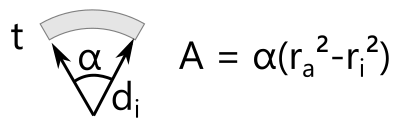

In [5]:
@interact(
    n = widgets.IntSlider(min=1000, max=100000, step=1000, value=22000), #rpm
    d_innen_mm = widgets.FloatSlider(min=10,max=500,step=.1,value=128), #mm Durchmesser am Inneren der Magnete
    t_mm = widgets.FloatSlider(min=0.1,max=50,step=.1,value=10), #mm Dicke bis zum Aussendurchmesser
    winkel_grad = widgets.FloatSlider(min=1, max=180, step=1, value=22.5), #° Winkel der Magnete
    laenge_mm = widgets.FloatSlider(min=0.1,max=500,step=.1,value=225), #mm Axiale Länge der Magneten
    drehmoment_Nm = widgets.FloatSlider(min=0.1,max=500,step=.1,value=200),
    T_minimal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=-15),
    T_maximal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=120),
    t_bandage_mm = widgets.FloatSlider(min=0.125,max=20,step=.125,value=1),#Nm in der Fügefläche der Magnete zu übertragendes Drehmoment
    rho = fixed(7.6), #g/cm³ Dichte des Magneten
    )
def minimalste_bandagendicke(n,d_innen_mm,t_mm,winkel_grad,laenge_mm,rho,drehmoment_Nm,t_bandage_mm,T_minimal_C,T_maximal_C,plot=True):
    ## Allgemeine Berechnungen
    # Fläche Kreisabschnitt
    d_a, d_i, s, alpha, d_s, t, alpha_s = sp.symbols('d_a d_i s alpha d_s t alpha_s')
    r_i = d_i/2
    r_a = r_i +t
    d_a = r_a*2
    #r_s = d_s/2
    #Magnet
    A_magnet = alpha/2*(r_a**2-r_i**2)
    #Schwerpunkt
    r_s = 2*(r_a**3-r_i**3)*sp.sin(alpha/2)/(3*(r_a**2-r_i**2)*alpha/2)
    #Oberfläche
    b_magnet = r_a*alpha
    ## Eingaben
    n = n #rpm
    t_magnet =t_mm*1e-3 #m dicke der Bandage
    d_innen = d_innen_mm*1e-3 #m Durchmesser am Inneren der Magnete
    d_aussen = d_innen+2*t_magnet #m Durchmesser am Äußeren der Magnete
    winkel = winkel_grad/180*np.pi #rad Winkelabschnitt der Magnete
    laenge = laenge_mm*1e-3 #m Länge des Magneten in axialer Richtung
    dichte = rho*1e3#kg/m³ Dichte des Magneten
    alpha_magnet = 12e-6
    alpha_sleeve = -1e-6
    T_wickeln = 30#°C
    T_minimal = T_minimal_C#°C
    T_maximal = T_maximal_C#°C
    E_bandage = 171032#130000 #N/mm²
    delta_T_kalt = T_wickeln-T_minimal
    delta_T_warm = T_wickeln-T_maximal
    alpha_result = alpha_magnet-alpha_sleeve
    eps_thermisch_kalt = delta_T_kalt*alpha_result
    sigma_thermisch_kalt = eps_thermisch_kalt*E_bandage
    eps_thermisch_warm = delta_T_warm*alpha_result
    sigma_thermisch_warm = eps_thermisch_warm*E_bandage
    
    # Einsetzen der aktuellen Geometrie des Magneten
    A_magnet_aktuell = A_magnet.evalf(subs={alpha: winkel, d_i: d_innen, t: t_magnet})
    b_magnet_aktuell = b_magnet.evalf(subs={alpha: winkel, d_i: d_innen, t: t_magnet})
    r_s_aktuell = r_s.evalf(subs={alpha: winkel, d_i: d_innen, t: t_magnet})
    # Weiterechnen mit "richtigen Zahlen"
    masse = A_magnet_aktuell*laenge*dichte
    omega = n/60*2*np.pi
    F_mag = masse*omega**2*r_s_aktuell
    pf_fliehkraft = F_mag/b_magnet_aktuell/laenge
    pf_drehmoment = drehmoment_Nm/(np.pi*d_innen**2*laenge*0.05)
    pf = pf_fliehkraft + pf_drehmoment
    t_bandage_min = float(pf*d_aussen*2e-10)
    mm = 1e3
    grad = 180/np.pi
    da_bandage_min = (d_aussen+2*t_bandage_min) * mm
    da_bandage_safe = (d_aussen+2*t_bandage_min*4) * mm
    da_magnet = d_aussen * mm
    di_magnet = d_innen * mm
    w = winkel * grad
    n_magnete=2*int(360/(w*2))
    w_offset = [90 + 360/n_magnete*i for i in range(n_magnete)]
    if plot:
        ## Ausgabe
        fig, ax = plt.subplots()
        #ax.add_patch(matplotlib.patches.Arc((0,0),da_bandage_safe,da_bandage_safe,90,-w/2,w/2,lw=2))

        #ax.add_patch(matplotlib.patches.Arc((0,0),da_magnet,da_magnet,90,-w/2,w/2,lw=2))
        #ax.add_patch(matplotlib.patches.Arc((0,0),di_magnet,di_magnet,90,-w/2,w/2,lw=2))
        [ax.add_patch(matplotlib.patches.Wedge((0,0), da_magnet/2, wo-w/2, wo+w/2, width=t_magnet*1e3,color='0.5')) for wo in w_offset]
        ax.add_patch(matplotlib.patches.Wedge((0,0), da_bandage_safe/2, 0, 180, width=t_bandage_min*4*1e3,color='0.8'))
        ax.add_patch(matplotlib.patches.Arc((0,0),da_bandage_min,da_bandage_min,90,-w/2,w/2,lw=1,ls='--'))
        #ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3+t_bandage_min*2e3,d_aussen*1e3+t_bandage_min*2e3,0,0,180,lw=2))
        ax.set_aspect("equal")
        plt.xlim([-da_bandage_safe/2,da_bandage_safe/2])
        plt.ylim([0,da_bandage_safe/2])
        plt.show()
        print(f'Magnet: D_aussen = {d_aussen*1e3:.2f} mm')
        print(f'Magnet: Masse = {masse*1e3:.3f} g')
        print(f'Magnet: Anzahl Magnete = {n_magnete}')
        print(f'Bandage: t_min_theoretisch = {t_bandage_min*1e3:.3f}(*) mm')
        print(f'Für {t_bandage_mm} mm Bandage:')
        vorspannung = d_aussen*1e3*pf*1e-6/2/t_bandage_mm
        rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
        print(f'Fliehkraft: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700,0.4545mm² --> {vorspannung:.3f} N/mm²)')
        vorspannung += sigma_thermisch_kalt
        rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
        print(f'Fliehkraft + Reserve um bei {T_wickeln}°C zu wickeln und {T_minimal}°C zu ertragen: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700, 0.4545mm² --> {vorspannung:.3f} N/mm²)')
        print(f'Übermaß um bei {T_wickeln}°C zu fügen und {T_minimal}°C zu ertragen: Dehnung = {vorspannung/E_bandage:.3f} --> bei Ø {d_aussen*1000:.2f} mm sind das {vorspannung/E_bandage*d_aussen*1000000:.0f} µm Übermaß)')

        vorspannung -= sigma_thermisch_warm
        rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
        print(f'Bei 120°C: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700, 0.4545mm² --> {vorspannung:.3f} N/mm²)')
            
        print(f'''\n(*)Achtung:\nDies entspricht einer bis zur theoretischen Festigkeitsgrenze vorgespannten Bandage aus Standard-Kohlenstofffasern\nEine realistische Bandage bedarf genauer Analyse müsste aber mindestens 4-mal so dick sein!''')
        print(f'Bandage: D_aussen = {da_bandage_safe:.2f} mm (bei vierfacher Bandagedicke)')
    return da_bandage_safe, t_bandage_min*4*1e3


interactive(children=(IntSlider(value=22000, description='n', max=100000, min=1000, step=1000), FloatSlider(va…

In [6]:
from IPython.display import display

n_rpm = widgets.IntSlider(min=1000, max=100000, step=1000, value=22000,description='n in rpm') #rpm
d_aussen_magnet_mm = widgets.FloatSlider(min=10,max=500,step=.1,value=128,description='OD in mm') #mm Durchmesser am äußeren der Magnete
m_magnet_g = widgets.FloatSlider(min=0.1,max=500,step=.1,value=414.8,description='mass in mm') #mm Masse eines Magnetsegments
winkel_magnet_grad = widgets.FloatSlider(min=1, max=180, step=1, value=22.5,description='span in °') #° Kontaktwinkel eines Magnets
r_cog_magnet_mm = widgets.FloatSlider(min=1, max=180, step=1, value=22.5,description='r_cog in mm') #° Winkel der Magnete
laenge_magnet_mm = widgets.FloatSlider(min=0.1,max=500,step=.1,value=225,description='length in mm') #mm Axiale Länge der Magneten
n_magnet_pcs = widgets.IntSlider(min=1, max=60, step=1, value=8,description='poles') #rpm
drehmoment_Nm = 0.1 # Falls der Pressverband das drehmoment übertragen muss
T_minimal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=-15,description='T_min in °C') #°C minimale Einsatztemperatur
T_maximal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=120,description='T_max in °C') #°C maximale Einsatztemperatur
t_bandage_mm = widgets.FloatSlider(min=0.125,max=20,step=.125,value=1,description='t in mm')#Nm in der Fügefläche der Magnete zu übertragendes Drehmoment
E_bandage_GPa = widgets.FloatSlider(min=1,max=1000,step=1,value=130,description='E in GPa')
alpha_bandage_e6 = widgets.FloatSlider(min=-50,max=50,step=1,value=-1,description='alpha in 1e-6')

tab_contents = ['General', 'Rotor', 'Sleeve']
children = [
    widgets.VBox([n_rpm,T_minimal_C,T_maximal_C]),
    widgets.VBox([d_aussen_magnet_mm,m_magnet_g,winkel_magnet_grad,r_cog_magnet_mm,laenge_magnet_mm,n_magnet_pcs]),
    widgets.VBox([t_bandage_mm,E_bandage_GPa,alpha_bandage_e6]),]
tab = widgets.Tab()
tab.children = children
tab.titles = ('General', 'Rotor', 'Sleeve')
for i,title in enumerate(tab_contents):
    tab.set_title(i, title)
display(tab)

In [11]:
# Vorgeben von Masse und Schwerpunkt und Anzahl der Magnete
from scipy.optimize import fmin
#@interact(
#    n_rpm = widgets.IntSlider(min=1000, max=100000, step=1000, value=n_rpm.value,description='n in rpm'), #rpm
#    d_aussen_magnet_mm = widgets.FloatSlider(min=10,max=500,step=.1,value=d_aussen_magnet_mm.value,description='OD in mm'), #mm Durchmesser am äußeren der Magnete
#    m_magnet_g = widgets.FloatSlider(min=0.1,max=500,step=.1,value=m_magnet_g.value,description='mass in mm'), #mm Masse eines Magnetsegments
#    winkel_magnet_grad = widgets.FloatSlider(min=1, max=180, step=1, value=winkel_magnet_grad.value,description='span in °'), #° Kontaktwinkel eines Magnets
#    r_cog_magnet_mm = widgets.FloatSlider(min=1, max=180, step=1, value=r_cog_magnet_mm.value,description='r_cog in mm'), #° Winkel der Magnete
#    laenge_magnet_mm = widgets.FloatSlider(min=0.1,max=500,step=.1,value=laenge_magnet_mm.value,description='length in mm'), #mm Axiale Länge der Magneten
#    n_magnet_pcs = widgets.IntSlider(min=1, max=60, step=1, value=n_magnet_pcs.value,description='poles'), #rpm
#    drehmoment_Nm = fixed(0.1), # Falls der Pressverband das drehmoment übertragen muss
#    T_minimal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=T_minimal_C.value,description='T_min in °C'), #°C minimale Einsatztemperatur
#    T_maximal_C = widgets.FloatSlider(min=-100,max=150,step=1,value=T_maximal_C.value,description='T_max in °C'), #°C maximale Einsatztemperatur
#    t_bandage_mm = widgets.FloatSlider(min=0.125,max=20,step=.125,value=t_bandage_mm.value,description='t in mm'),#Nm in der Fügefläche der Magnete zu übertragendes Drehmoment
#    E_bandage_GPa = widgets.FloatSlider(min=1,max=1000,step=1,value=E_bandage_GPa.value,description='E in GPa'),
#    alpha_bandage_e6 = widgets.FloatSlider(min=-50,max=50,step=1,value=alpha_bandage_e6.value,description='alpha in 1e-6'),)
#@interact(
#        n_rpm,
#        d_aussen_magnet_mm,
#        m_magnet_g=m_magnet_g,
#        winkel_magnet_grad=winkel_magnet_grad,
#        r_cog_magnet_mm=r_cog_magnet_mm,
#        laenge_magnet_mm=laenge_magnet_mm,
 #       n_magnet_pcs=n_magnet_pcs,
 #       drehmoment_Nm=drehmoment_Nm,
 ##       T_minimal_C=T_minimal_C,
 #       T_maximal_C=T_maximal_C,
 #       t_bandage_mm=t_bandage_mm,
  #      E_bandage_GPa=E_bandage_GPa,
  #      alpha_bandage_e6=alpha_bandage_e6)
def minimalste_bandagendicke(
        n_rpm=n_rpm,
        d_aussen_magnet_mm=d_aussen_magnet_mm,
        m_magnet_g=m_magnet_g,
        winkel_magnet_grad=winkel_magnet_grad,
        r_cog_magnet_mm=r_cog_magnet_mm,
        laenge_magnet_mm=laenge_magnet_mm,
        n_magnet_pcs=n_magnet_pcs,
        drehmoment_Nm=drehmoment_Nm,
        T_minimal_C=T_minimal_C,
        T_maximal_C=T_maximal_C,
        t_bandage_mm=t_bandage_mm,
        E_bandage_GPa=E_bandage_GPa,
        alpha_bandage_e6=alpha_bandage_e6,
        plot=True):
    ## Allgemeine Berechnungen
    # Fläche Kreisabschnitt
    d_a, d_i, s, alpha, d_s, t, alpha_s = sp.symbols('d_a d_i s alpha d_s t alpha_s')
    r_i = d_i/2
    r_a = r_i +t
    d_a = r_a*2
    #r_s = d_s/2
    #Magnet
    A_magnet = alpha/2*(r_a**2-r_i**2)
    #Schwerpunkt
    def r_s(r_a,r_i,alpha):
        return 2*(r_a**3-r_i**3)*np.sin(alpha/2)/(3*(r_a**2-r_i**2)*alpha/2)
    #Oberfläche
    b_magnet = r_a*alpha
    in_m = 1e-3
    in_mm = 1e3
    in_rad = 1./180.*np.pi
    in_grad = 1/in_rad
    in_kg = 1e-3
    ## Eingaben
    n = n_rpm #rpm

    winkel = winkel_magnet_grad*in_rad #rad Winkelabschnitt der Magnete
    laenge = laenge_magnet_mm*in_m #m Länge des Magneten in axialer Richtung
    #dichte = rho*1e3#kg/m³ Dichte des Magneten
    d_aussen = d_aussen_magnet_mm*in_m
    alpha_magnet = 12e-6
    alpha_sleeve = alpha_bandage_e6*1e-6
    T_wickeln = 30#°C
    T_minimal = T_minimal_C#°C
    T_maximal = T_maximal_C#°C
    E_bandage = E_bandage_GPa*1e3#130000 #N/mm²
    delta_T_kalt = T_wickeln-T_minimal
    delta_T_warm = T_wickeln-T_maximal
    alpha_result = alpha_magnet-alpha_sleeve
    eps_thermisch_kalt = delta_T_kalt*alpha_result
    sigma_thermisch_kalt = eps_thermisch_kalt*E_bandage
    eps_thermisch_warm = delta_T_warm*alpha_result
    sigma_thermisch_warm = eps_thermisch_warm*E_bandage
    
    # Einsetzen der aktuellen Geometrie des Magneten
    
    b_magnet_aktuell = winkel*d_aussen/2
    r_s_aktuell = r_cog_magnet_mm*in_m
    r_s_fehler = lambda d_innen: (r_s_aktuell-r_s(r_a =d_aussen/2,r_i=d_innen/2, alpha=winkel))**2
    d_innen = fmin(r_s_fehler,d_aussen-4*(d_aussen-2*r_s_aktuell))[0]
    t_magnet = (d_aussen-d_innen)/2
    A_magnet_aktuell = A_magnet.evalf(subs={alpha: winkel, d_i: d_innen, t: t_magnet})
    # Weiterechnen mit "richtigen Zahlen"
    masse = m_magnet_g*in_kg
    omega = n/60*2*np.pi
    F_mag = masse*omega**2*r_s_aktuell
    pf_fliehkraft = F_mag/b_magnet_aktuell/laenge
    pf_drehmoment = drehmoment_Nm/(np.pi*d_innen**2*laenge*0.05)
    pf = pf_fliehkraft + pf_drehmoment
    t_bandage_min = float(pf*d_aussen*2e-10)
    da_bandage_min = (d_aussen+2*t_bandage_min) * in_mm
    da_bandage_safe = (d_aussen+2*t_bandage_min*4) * in_mm
    da_bandage_input = (d_aussen+2*t_bandage_mm*in_m) * in_mm
    da_magnet = d_aussen * in_mm
    di_magnet = d_innen * in_mm
    w = winkel * in_grad
    n_magnete=min(2*int(360/(w*2)),n_magnet_pcs)
    w_offset = [90 + 360/n_magnete*i for i in range(n_magnete)]
    if plot:
        ## Ausgabe
        out = widgets.Output(layout={'border': '1px solid black'})
        with out:
            fig, ax = plt.subplots()
            #ax.add_patch(matplotlib.patches.Arc((0,0),da_bandage_safe,da_bandage_safe,90,-w/2,w/2,lw=2))

            #ax.add_patch(matplotlib.patches.Arc((0,0),da_magnet,da_magnet,90,-w/2,w/2,lw=2))
            #ax.add_patch(matplotlib.patches.Arc((0,0),di_magnet,di_magnet,90,-w/2,w/2,lw=2))
            [ax.add_patch(matplotlib.patches.Wedge((0,0), da_magnet/2, wo-w/2, wo+w/2, width=t_magnet*1e3,color='0.5')) for wo in w_offset]
            ax.add_patch(matplotlib.patches.Wedge((0,0), da_bandage_input/2, 0, 180, width=t_bandage_mm,color='0.8'))
            ax.add_patch(matplotlib.patches.Arc((0,0),da_bandage_min,da_bandage_min,90,-w/2,w/2,lw=1,ls='--'))
            #ax.add_patch(matplotlib.patches.Arc((breite*1e3/2,-d_innen/2*1e3),d_aussen*1e3+t_bandage_min*2e3,d_aussen*1e3+t_bandage_min*2e3,0,0,180,lw=2))
            ax.set_aspect("equal")
            plt.xlim([-da_bandage_safe/2,da_bandage_safe/2])
            plt.ylim([0,da_bandage_safe/2])
            plt.show()
            print(f'Magnet: D_aussen = {d_aussen*1e3:.2f} mm')
            print(f'Magnet: Masse = {masse*1e3:.3f} g')
            print(f'Magnet: Anzahl Magnete = {n_magnete}')
            print(f'Bandage: t_min_theoretisch = {t_bandage_min*1e3:.3f}(*) mm')
            print(f'Für {t_bandage_mm} mm Bandage:')
            vorspannung = d_aussen*1e3*pf*1e-6/2/t_bandage_mm
            rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
            print(f'Fliehkraft: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700,0.4545mm² --> {vorspannung:.3f} N/mm²)')
            vorspannung += sigma_thermisch_kalt
            rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
            print(f'Fliehkraft + Reserve um bei {T_wickeln}°C zu wickeln und {T_minimal}°C zu ertragen: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700, 0.4545mm² --> {vorspannung:.3f} N/mm²)')
            print(f'Übermaß um bei {T_wickeln}°C zu fügen und {T_minimal}°C zu ertragen: Dehnung = {vorspannung/E_bandage:.3f} --> bei Ø {d_aussen*1000:.2f} mm sind das {vorspannung/E_bandage*d_aussen*1000000:.0f} µm Übermaß)')

            vorspannung -= sigma_thermisch_warm
            rovingkraft = vorspannung*0.454545 #N (800tex rho_faser 1,76 g/cm³)
            print(f'Bei {T_maximal}°C: Fvorspannung = {rovingkraft:.3f}(*) N (800 tex T700, 0.4545mm² --> {vorspannung:.3f} N/mm²)')

            print(f'''\n(*)Achtung:\nDies entspricht einer bis zur theoretischen Festigkeitsgrenze vorgespannten Bandage aus Standard-Kohlenstofffasern\nEine realistische Bandage bedarf genauer Analyse müsste aber mindestens 4-mal so dick sein!''')
            print(f'Bandage: D_aussen = {da_bandage_safe:.2f} mm (bei vierfacher Bandagedicke)')
        display(out)
    return [da_bandage_safe, t_bandage_min*4*1e3]


In [23]:
button = widgets.Button(
    description='Berechnen',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
output = [1, 2]
items = [widgets.Label(str(o)) for o in output]
box=widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))
display(box)
def calculate(*ignore):
        global output
        output=minimalste_bandagendicke(
            n_rpm.value,
            d_aussen_magnet_mm.value,
            m_magnet_g.value,
            winkel_magnet_grad.value,
            r_cog_magnet_mm.value,
            laenge_magnet_mm.value,
            n_magnet_pcs.value,
            drehmoment_Nm,
            T_minimal_C.value,
            T_maximal_C.value,
            t_bandage_mm.value,
            E_bandage_GPa.value,
            alpha_bandage_e6.value,
            plot=True)
        [items[i].value == str(o) for i,o in enumerate(output)]
        display(box)
button.on_click(calculate)
display(button)



GridBox(children=(Label(value='1'), Label(value='2')), layout=Layout(grid_template_columns='repeat(3, 100px)')…

Button(description='Berechnen', icon='check', style=ButtonStyle(), tooltip='Click me')

Optimization terminated successfully.
         Current function value: 0.022404
         Iterations: 11
         Function evaluations: 22


Output(layout=Layout(border='1px solid black'))

GridBox(children=(Label(value='1'), Label(value='2')), layout=Layout(grid_template_columns='repeat(3, 100px)')…